# Resnet + Transfer Learning
 
Notebook para testar o uso da Renet para uma nova aplicação, através do uso de Transfer Learning.

Iremos usar o tensorflow e keras

será usado o problema de classificação de imagens de celulas sangue

In [25]:
import tensorflow as tf

print(tf.__version__)

2.11.0


In [18]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.resnet import ResNet50, preprocess_input
# from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import load_img, img_to_array
from keras.optimizers import Adam


from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

from glob import glob

#### variaveis uteis

In [3]:

IMAGE_SIZE = [224, 224] 

In [4]:
# training config:
epochs = 16
batch_size = 128

#### dataset

In [6]:
# para funcionar no colab 
!wget -nc https://lazyprogrammer.me/course_files/blood_cell_images.zip

--2023-03-16 19:13:28--  https://lazyprogrammer.me/course_files/blood_cell_images.zip
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109834540 (105M) [application/zip]
Saving to: ‘blood_cell_images.zip’

blood_cell_images.z 100%[===================>] 104.75M   322KB/s    in 4m 47s  

2023-03-16 19:18:15 (374 KB/s) - ‘blood_cell_images.zip’ saved [109834540/109834540]



In [7]:
# colab tb - descompaquitando arquivo
!unzip -nq blood_cell_images.zip

In [8]:
train_path = 'blood_cell_images/TRAIN/'
valid_path = 'blood_cell_images/TEST/'

In [9]:
# numero de arquivos
image_files = glob(train_path + '/*/*.jp*g')
valid_image_files = glob(valid_path + '/*/*.jp*g')

In [10]:
print(len(image_files), len(valid_image_files))

9957 2487


In [11]:
# numero de classes
folders = glob(train_path + '/*')

print(len(folders))

4


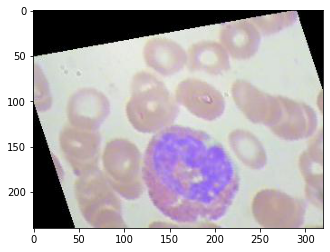

In [12]:
# verificando uma imagem
plt.imshow(load_img(np.random.choice(image_files)))
plt.show()

### Model

In [13]:
# removando a ultima camada da rede para realizarmos o treinamento posterior
res = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

94765736/94765736 [==============================] - 0s 0us/step


In [14]:
# congelando os pesos para não serem treinados
for layer in res.layers:
  layer.trainable = False


In [15]:
# nova camada sendo adicionada com o numero de saidas igual ao numero de classes
x = Flatten()(res.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

In [16]:
# juntando tudo em um objeto model
model = Model(inputs=res.input, outputs=prediction)

In [17]:
# visualizando estrutura da rede
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [19]:
# definido função de custo e otimizador
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer= Adam(learning_rate=0.0001),
  metrics=['accuracy']
)

In [20]:
# criar instancia do ImageDataGenerator
train_gen = ImageDataGenerator(
  rotation_range=20,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.1,
  zoom_range=0.2,
  horizontal_flip=True,
  vertical_flip=True,
  preprocessing_function=preprocess_input
)

In [21]:
val_gen = ImageDataGenerator( preprocessing_function=preprocess_input)

In [22]:
# get label mapping for confusion matrix plot later
test_gen = train_gen.flow_from_directory(valid_path, target_size=IMAGE_SIZE)
print(test_gen.class_indices)
labels = [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
  labels[v] = k

Found 2487 images belonging to 4 classes.
{'EOSINOPHIL': 0, 'LYMPHOCYTE': 1, 'MONOCYTE': 2, 'NEUTROPHIL': 3}


min: -123.68 max: 151.061


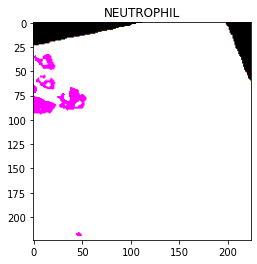

In [23]:
# vissualizar uma amostra
for x, y in test_gen:
  print("min:", x[0].min(), "max:", x[0].max())
  plt.title(labels[np.argmax(y[0])])
  plt.imshow(x[0])
  plt.show()
  break


In [24]:
# create generators
train_generator = train_gen.flow_from_directory(
  train_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
  class_mode='sparse'
)
valid_generator = val_gen.flow_from_directory(
  valid_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
  class_mode='sparse'
)

Found 9957 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.


 - treinamento

In [26]:
# fit the model
r = model.fit(
  train_generator,
  validation_data=valid_generator,
  epochs=epochs,
  steps_per_epoch=len(image_files) // batch_size,
  validation_steps=len(valid_image_files) // batch_size,
  callbacks = [
      tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)
  ]
)

Epoch 1/16
77/77 [==============================] - 155s 2s/step - loss: 1.8339 - accuracy: 0.4516 - val_loss: 1.3343 - val_accuracy: 0.5086
Epoch 2/16
77/77 [==============================] - 149s 2s/step - loss: 1.0283 - accuracy: 0.6231 - val_loss: 1.3257 - val_accuracy: 0.5411
Epoch 3/16
77/77 [==============================] - 136s 2s/step - loss: 0.8216 - accuracy: 0.6965 - val_loss: 1.2584 - val_accuracy: 0.5921
Epoch 4/16
77/77 [==============================] - 136s 2s/step - loss: 0.6912 - accuracy: 0.7450 - val_loss: 1.2210 - val_accuracy: 0.6003
Epoch 5/16
77/77 [==============================] - 137s 2s/step - loss: 0.6140 - accuracy: 0.7715 - val_loss: 1.4879 - val_accuracy: 0.5440
Epoch 6/16
77/77 [==============================] - 137s 2s/step - loss: 0.5489 - accuracy: 0.7926 - val_loss: 1.3776 - val_accuracy: 0.5826
Epoch 7/16
77/77 [==============================] - 136s 2s/step - loss: 0.4988 - accuracy: 0.8162 - val_loss: 1.2401 - val_accuracy: 0.6209
Epoch 8/16
77

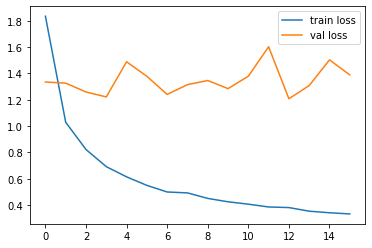

In [28]:
# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()


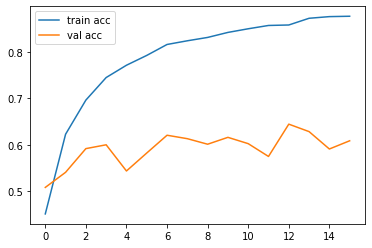

In [29]:
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [33]:
def get_confusion_matrix(data_path, N):
  # we need to see the data in the same order
  # for both predictions and targets
  print("Generating confusion matrix", N)
  predictions = []
  targets = []
  i = 0
  for x, y in val_gen.flow_from_directory(data_path, target_size=IMAGE_SIZE, shuffle=False, batch_size=batch_size * 2):
    i += 1
    if i % 50 == 0:
      print(i)
    p = model.predict(x)
    p = np.argmax(p, axis=1)
    y = np.argmax(y, axis=1)
    predictions = np.concatenate((predictions, p))
    targets = np.concatenate((targets, y))
    if len(targets) >= N:
      break

  cm = confusion_matrix(targets, predictions)
  return cm

In [34]:
cm = get_confusion_matrix(train_path, len(image_files))
print(cm)
valid_cm = get_confusion_matrix(valid_path, len(valid_image_files))
print(valid_cm)

Generating confusion matrix 9957
Found 9957 images belonging to 4 classes.
8/8 [==============================] - 2s 156ms/step
[[2403    6   25   63]
 [  65 2398   12    8]
 [  10    1 2467    0]
 [ 432   24   62 1981]]
Generating confusion matrix 2487
Found 2487 images belonging to 4 classes.
6/6 [==============================] - 1s 227ms/step
[[422  33  45 123]
 [156 373  62  29]
 [225   0 335  60]
 [201  14  28 381]]


In [37]:
np.trace(cm)/ cm.sum()

0.9288942452545947

In [38]:
np.trace(valid_cm)/ valid_cm.sum()

0.6075593084036992